In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams



In [2]:

# Combine Voyage Prive files
voyageprive_files = glob.glob("../../data/voyageprive_hotels_*.csv")
voyageprive_data = pd.concat([pd.read_csv(file) for file in voyageprive_files], ignore_index=True)

# Combine Verychic files
verychic_files = glob.glob("../../data/verychic_hotels_*.csv")
verychic_data = pd.concat([pd.read_csv(file) for file in verychic_files], ignore_index=True)


In [3]:
# Clean Voyage Prive data
voyageprive_data['price'] = voyageprive_data['price'].str.extract(r'(\d+\.?\d*)').astype(float)
voyageprive_data.rename(columns={'Country': 'country', 'hotel_name': 'hotel_name', 
                                  'start_date': 'start_date', 'end_date': 'end_date'}, inplace=True)

# Clean Verychic data
verychic_data.rename(columns={'Country': 'country', 'hotel_name': 'hotel_name', 
                               'start_date': 'start_date', 'end_date': 'end_date', 'Price': 'price'}, inplace=True)

# Convert dates to datetime
voyageprive_data['start_date'] = pd.to_datetime(voyageprive_data['start_date'])
voyageprive_data['end_date'] = pd.to_datetime(voyageprive_data['end_date'])
verychic_data['start_date'] = pd.to_datetime(verychic_data['start_date'])
verychic_data['end_date'] = pd.to_datetime(verychic_data['end_date'])


In [4]:
def process_dataframe(df):
    """
    Preprocess the 'hotel_name' column in the dataframe to standardize names by:
    - Converting to lowercase
    - Replacing accented characters with unaccented equivalents
    - Removing spaces, special characters, and digits
    - Removing common keywords like 'hotel'

    Parameters:
        df (pd.DataFrame): Dataframe with a 'hotel_name' column to preprocess.

    Returns:
        pd.DataFrame: Dataframe with the preprocessed 'hotel_name' column.
    """
    df['hotel_name_original'] = df['hotel_name']
    df['hotel_name'] = (
        df['hotel_name']
        .str.lower()
        .str.replace('ô', 'o')
        .str.replace('é', 'e')
        .str.replace('è', 'e')
        .str.replace('hotel', '')
        .str.replace('1', '')
        .str.replace('2', '')
        .str.replace('3', '')
        .str.replace('4', '')
        .str.replace('5', '')
        .str.replace('6', '')
        .str.replace('7', '')
        .str.replace('8', '')
        .str.replace('9', '')
        .str.replace('[^a-zA-Z0-9]', '', regex=True)  # Remove all special characters
    )

    # round dates to seconds to avoid floating point errors
    df['start_date'] = pd.to_datetime(df['start_date']).dt.round('s')
    df['end_date'] = pd.to_datetime(df['end_date']).dt.round('s')
    return df

In [5]:
# Restyled Plot for Daily Overlapping Deals
# plt.figure(figsize=(8, 3))  # Set figure size
# Find overlaps
voyageprive_cleaned = process_dataframe(voyageprive_data)
verychic_cleaned = process_dataframe(verychic_data)


overlapping_deals = pd.merge(voyageprive_cleaned, verychic_cleaned, on='hotel_name', suffixes=('_vp', '_vc'))
overlapping_deals = overlapping_deals[
    (overlapping_deals['start_date_vp'] <= overlapping_deals['end_date_vc']) &
    (overlapping_deals['end_date_vp'] >= overlapping_deals['start_date_vc'])
]




In [6]:
# Calculate overlapping hours
overlapping_deals['overlap_hours'] = (
    (
        pd.concat([
            overlapping_deals[['start_date_vp', 'start_date_vc']].max(axis=1),  # Maximum of the two start dates
            overlapping_deals[['end_date_vp', 'end_date_vc']].min(axis=1)       # Minimum of the two end dates
        ], axis=1).diff(axis=1).iloc[:, -1]  # Calculate the difference (end - start)
    )
    .dt.total_seconds() / 3600  # Convert seconds to hours
).clip(lower=0)  # Ensure no negative overlaps


In [23]:
overlapping_deals.columns

Index(['country_vp', 'hotel_name', 'price_vp', 'time_remaining',
       'start_date_vp', 'end_date_vp', 'hotel_name_original_vp', 'City',
       'country_vc', 'Category', 'price_vc', 'Discount', 'start_date_vc',
       'end_date_vc', 'Dernière Minute', 'hotel_name_original_vc',
       'overlap_hours'],
      dtype='object')

In [17]:


# remove duplicates wrt columns 'hotel_name', 'start_date_vp', 'end_date_vp', 'start_date_vc', 'end_date_vc'
overlapping_deals = overlapping_deals.drop_duplicates(subset=['hotel_name', 'start_date_vp', 'end_date_vp', 'start_date_vc', 'end_date_vc'])

# Display the updated dataframe with the overlap_hours column
overlapping_deals[['hotel_name', 'start_date_vp', 'end_date_vp', 'start_date_vc', 'end_date_vc', 'overlap_hours']].head(1000)


,hotel_name,start_date_vp,end_date_vp,start_date_vc,end_date_vc,overlap_hours
3,arrecifegranspa,2025-01-10 14:17:26,2025-01-16 14:17:26,2024-12-31 00:05:00,2025-01-10 23:55:00,9.626111
4,unasalaveneziaadultsonly,2025-01-10 14:17:26,2025-01-16 14:17:26,2025-01-09 00:05:00,2025-01-18 23:55:00,144.000000
17,radissoncollectionromaantica,2025-01-10 14:17:26,2025-01-12 14:17:26,2025-01-09 00:05:00,2025-01-11 23:55:00,33.626111
18,radissoncollectionromaantica,2025-01-10 14:17:26,2025-01-12 14:17:26,2025-01-12 00:05:00,2025-01-26 23:55:00,14.207222
19,radissoncollectionromaantica,2025-01-10 14:17:26,2025-01-12 14:17:26,2025-01-12 00:05:00,2025-01-22 23:55:00,14.207222
30,lelouisversailleschteaumgallery,2025-01-10 14:17:26,2025-01-11 14:17:26,2024-12-12 00:05:00,2025-01-12 23:55:00,24.000000
39,palazzobelvedere,2025-01-22 13:07:09,2025-01-23 00:59:09,2025-01-22 00:05:00,2025-01-28 23:55:00,11.866667
50,sheratonjumeirahbeachresort,2025-01-19 14:30:36,2025-01-23 14:30:36,2025-01-19 00:05:00,2025-01-25 23:55:00,96.000000
53,palazzobelvedere,2025-01-19 14:30:36,2025-01-22 14:30:36,2025-01-22 00:05:00,2025-01-28 23:55:00,14.426667
54,palazzobelvedere,2025-01-19 14:30:36,2025-01-22 14:30:36,2025-01-21 00:05:00,2025-01-21 23:55:00,23.833333


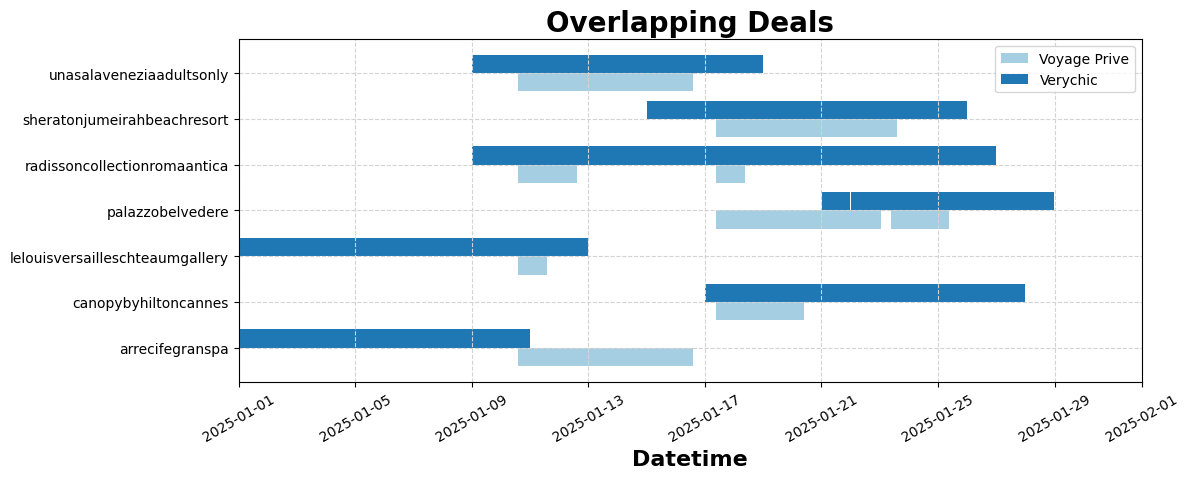

In [52]:
# Debugging and validating date ranges
def validate_and_correct_dates(df):
    """
    Ensures that start_date and end_date are properly parsed and that
    end_date is after start_date. If not, log the issue and correct it.
    """
    for col in ['start_date_vp', 'end_date_vp', 'start_date_vc', 'end_date_vc']:
        df[col] = pd.to_datetime(df[col], errors='coerce')  # Ensure all dates are datetime
    df = df.dropna(subset=['start_date_vp', 'end_date_vp', 'start_date_vc', 'end_date_vc'])  # Drop rows with invalid dates

    # Ensure end_date is after start_date
    df = df[df['end_date_vp'] > df['start_date_vp']]
    df = df[df['end_date_vc'] > df['start_date_vc']]
    return df


# Set the theme
plt.style.use('default')  # Default light theme
rcParams['grid.color'] = 'lightgray'  # Light gray gridlines
rcParams['grid.linestyle'] = '--'  # Dashed gridlines
rcParams['axes.facecolor'] = 'white'  # White axes background
rcParams['axes.edgecolor'] = 'black'  # Black axes edge
rcParams['axes.grid'] = True  # Enable grid
rcParams['axes.titleweight'] = 'bold'  # Bold titles

# Set a color palette similar to 'Paired'
colors = plt.cm.Paired.colors

# Validate and correct overlapping_deals
overlapping_deals = validate_and_correct_dates(overlapping_deals)

# Updated plotting logic
fig, ax = plt.subplots(figsize=(12, len(overlapping_deals['hotel_name'].unique()) * 0.7))

# Sort by hotel name for better organization
overlapping_deals = overlapping_deals.sort_values('hotel_name')

# Create a mapping of hotels to y-axis positions
hotels = overlapping_deals['hotel_name'].unique()
hotel_indices = {hotel: idx for idx, hotel in enumerate(hotels)}

# Iterate over each row to create blocks
for _, row in overlapping_deals.iterrows():
    # Get the y position for the hotel
    y_pos = hotel_indices[row['hotel_name']]

    # Plot Voyage Prive (blue)
    ax.barh(
        y=y_pos - 0.2,  # Adjust to place the bar slightly below the center
        width=(row['end_date_vp'] - row['start_date_vp']),
        left=row['start_date_vp'],  # Start time
        height=0.4,  # Thickness of the bar
        color=colors[0],
        label="Voyage Prive" if y_pos == 0 else "",  # Add label only for the first bar
    )

    # Plot Verychic (orange)
    ax.barh(
        y=y_pos + 0.2,  # Adjust to place the bar slightly above the center
        width=(row['end_date_vc'] - row['start_date_vc']),
        left=row['start_date_vc'],  # Start time
        height=0.4,  # Thickness of the bar
        color=colors[1],
        label="Verychic" if y_pos == 0 else "",  # Add label only for the first bar
    )

# Customize the y-axis
ax.set_yticks(list(hotel_indices.values()))
ax.set_yticklabels(hotels)

# Customize the x-axis
ax.xaxis_date()  # Use date format for the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=30)
# set xlim to january first 2025
ax.set_xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-02-01'))

# Add labels and title
ax.set_xlabel("Datetime",fontsize=16, fontweight='bold')
ax.set_title("Overlapping Deals", fontweight='bold', fontsize=20)

# Add a legend
ax.legend(loc="upper right")

# Adjust layout and show the plot
plt.savefig('../../plots/block_schedule_overlapping_deals.png')
plt.tight_layout()
plt.show()
